# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 32  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 32]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] /5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29702.923828125
iteration 0 loss 18298.8671875


iteration 500 loss 191.6780548095703


iteration 1000 loss 170.82150268554688


iteration 1500 loss 146.31529235839844


iteration 2000 loss 99.69801330566406


iteration 2500 loss 22.010589599609375


iteration 3000 loss 10.120417594909668


iteration 3500 loss 7.69494104385376


iteration 4000 loss 5.827711582183838


iteration 4500 loss 4.374247074127197


iteration 5000 loss 4.00092887878418


iteration 5500 loss 3.383150577545166


iteration 6000 loss 2.8977441787719727


iteration 6500 loss 2.471524238586426


iteration 7000 loss 2.614596128463745


iteration 7500 loss 2.184648275375366


iteration 8000 loss 1.973145604133606


iteration 8500 loss 1.7960814237594604


iteration 9000 loss 1.6298332214355469


iteration 9500 loss 1.896269679069519


iteration 10000 loss 1.6163655519485474


iteration 10500 loss 1.4861468076705933


iteration 11000 loss 1.384045124053955


iteration 11500 loss 1.2911688089370728


iteration 12000 loss 1.285491943359375


iteration 12500 loss 1.177189826965332


iteration 13000 loss 1.108077883720398


iteration 13500 loss 1.1596680879592896


iteration 14000 loss 1.0739670991897583


iteration 14500 loss 1.019368052482605


iteration 15000 loss 0.9703986048698425


iteration 15500 loss 1.0196183919906616


iteration 16000 loss 0.9514042735099792


iteration 16500 loss 0.908279299736023


iteration 17000 loss 0.8709458708763123


iteration 17500 loss 0.9157117009162903


iteration 18000 loss 0.8578667640686035


iteration 18500 loss 0.8225446939468384


iteration 19000 loss 0.7914401888847351


iteration 19500 loss 0.7981405854225159


iteration 20000 loss 0.7630547285079956


iteration 20500 loss 5.0743913650512695


iteration 21000 loss 0.7452071309089661


iteration 21500 loss 0.7150207757949829


iteration 22000 loss 12.678244590759277


iteration 22500 loss 0.746700644493103


iteration 23000 loss 0.7011562585830688


iteration 23500 loss 0.6750898957252502


iteration 24000 loss 0.6541404128074646


iteration 24500 loss 0.6614928841590881


iteration 25000 loss 0.6360187530517578


iteration 25500 loss 1.4977108240127563


iteration 26000 loss 0.6780025959014893


iteration 26500 loss 0.6328396201133728


iteration 27000 loss 0.6091865301132202


iteration 27500 loss 0.5912213921546936


iteration 28000 loss 0.6147482991218567


iteration 28500 loss 0.5845722556114197


iteration 29000 loss 0.5686461925506592


iteration 29500 loss 0.6082252264022827


iteration 30000 loss 0.5652759671211243


iteration 30500 loss 0.547468364238739


iteration 31000 loss 0.6305299401283264


iteration 31500 loss 0.5438298583030701


iteration 32000 loss 0.5263991355895996


iteration 32500 loss 0.5509473085403442


iteration 33000 loss 0.5172871947288513


iteration 33500 loss 0.5047898888587952


iteration 34000 loss 0.5475212931632996


iteration 34500 loss 0.5127497315406799


iteration 35000 loss 0.4969588816165924


iteration 35500 loss 89.36602020263672


iteration 36000 loss 0.5002880692481995


iteration 36500 loss 0.4823998808860779


iteration 37000 loss 0.4718273878097534


iteration 37500 loss 0.47381240129470825


iteration 38000 loss 0.4627366065979004


iteration 38500 loss 0.47386857867240906


iteration 39000 loss 0.45708250999450684


iteration 39500 loss 0.556324303150177


iteration 40000 loss 0.45453983545303345


iteration 40500 loss 0.4430640935897827


iteration 41000 loss 0.45894622802734375


iteration 41500 loss 0.43859413266181946


iteration 42000 loss 0.4312942326068878


iteration 42500 loss 0.44800350069999695


iteration 43000 loss 0.43026238679885864


iteration 43500 loss 0.4217618405818939


iteration 44000 loss 0.42998006939888


iteration 44500 loss 0.41672801971435547


iteration 45000 loss 0.4457210898399353


iteration 45500 loss 0.4137081801891327


iteration 46000 loss 0.40605342388153076


iteration 46500 loss 0.4108605980873108


iteration 47000 loss 0.399116188287735


iteration 47500 loss 0.40890029072761536


iteration 48000 loss 0.3951379656791687


iteration 48500 loss 0.4048044681549072


iteration 49000 loss 0.3881140351295471


iteration 49500 loss 0.3960474133491516


iteration 50000 loss 0.38261908292770386


iteration 50500 loss 0.4053613543510437


iteration 51000 loss 0.38119232654571533


iteration 51500 loss 0.37511956691741943


iteration 52000 loss 0.38006943464279175


iteration 52500 loss 0.37000572681427


iteration 53000 loss 0.3714400827884674


iteration 53500 loss 0.4120114743709564


iteration 54000 loss 0.3616279065608978


iteration 54500 loss 0.36050158739089966


iteration 55000 loss 0.36467480659484863


iteration 55500 loss 0.36688196659088135


iteration 56000 loss 0.35713183879852295


iteration 56500 loss 0.3801681101322174


iteration 57000 loss 0.3506961762905121


iteration 57500 loss 0.36460402607917786


iteration 58000 loss 0.34578245878219604


iteration 58500 loss 0.35006824135780334


iteration 59000 loss 0.3403438925743103


iteration 59500 loss 0.3418983519077301


iteration 60000 loss 5.094476222991943


iteration 60500 loss 0.33888939023017883


iteration 61000 loss 0.3324604630470276


iteration 61500 loss 0.33870258927345276


iteration 62000 loss 0.3303108513355255


iteration 62500 loss 0.3320438861846924


iteration 63000 loss 0.36025282740592957


iteration 63500 loss 0.32567113637924194


iteration 64000 loss 0.3279082477092743


iteration 64500 loss 0.3205932676792145


iteration 65000 loss 0.32082876563072205


iteration 65500 loss 0.321396142244339


iteration 66000 loss 0.32082659006118774


iteration 66500 loss 0.31949037313461304


iteration 67000 loss 0.31748339533805847


iteration 67500 loss 0.31661078333854675


iteration 68000 loss 0.3176628351211548


iteration 68500 loss 0.3379431664943695


iteration 69000 loss 0.6365031003952026


iteration 69500 loss 0.3056599795818329


iteration 70000 loss 0.30440112948417664


iteration 70500 loss 0.3032170236110687


iteration 71000 loss 0.3014732897281647


iteration 71500 loss 0.30206817388534546


iteration 72000 loss 0.30142852663993835


iteration 72500 loss 0.2996102571487427


iteration 73000 loss 0.2983340322971344


iteration 73500 loss 0.29645222425460815


iteration 74000 loss 0.2951667010784149


iteration 74500 loss 0.2948841452598572


iteration 75000 loss 0.2951415479183197


iteration 75500 loss 0.29727184772491455


iteration 76000 loss 0.2880421280860901


iteration 76500 loss 0.2882472276687622


iteration 77000 loss 0.2878384292125702


iteration 77500 loss 0.28616294264793396


iteration 78000 loss 0.285215824842453


iteration 78500 loss 0.2840079665184021


iteration 79000 loss 0.28315380215644836


iteration 79500 loss 0.28435131907463074


iteration 80000 loss 0.28374969959259033


iteration 80500 loss 0.2804723083972931


iteration 81000 loss 0.2779580354690552


iteration 81500 loss 0.27585023641586304


iteration 82000 loss 0.2748187780380249


iteration 82500 loss 0.2743546664714813


iteration 83000 loss 0.2729647755622864


iteration 83500 loss 0.31740111112594604


iteration 84000 loss 0.2749292254447937


iteration 84500 loss 0.27216991782188416


iteration 85000 loss 0.2695552706718445


iteration 85500 loss 0.26833397150039673


iteration 86000 loss 0.26718026399612427


iteration 86500 loss 2.49861216545105


iteration 87000 loss 0.2671012282371521


iteration 87500 loss 0.2646377980709076


iteration 88000 loss 1.2813010215759277


iteration 88500 loss 0.2640537619590759


iteration 89000 loss 0.2640574276447296


iteration 89500 loss 0.2701420485973358


iteration 90000 loss 0.2626297175884247


iteration 90500 loss 0.25962069630622864


iteration 91000 loss 0.25837790966033936


iteration 91500 loss 0.26116737723350525


iteration 92000 loss 0.7695867419242859


iteration 92500 loss 0.25771066546440125


iteration 93000 loss 0.25643831491470337


iteration 93500 loss 0.2558346688747406


iteration 94000 loss 0.2545291781425476


iteration 94500 loss 0.2523499131202698


iteration 95000 loss 0.25130048394203186


iteration 95500 loss 0.33474358916282654


iteration 96000 loss 0.37682923674583435


iteration 96500 loss 28.80115509033203


iteration 97000 loss 0.2519259750843048


iteration 97500 loss 0.24905870854854584


iteration 98000 loss 0.24721460044384003


iteration 98500 loss 0.2505311071872711


iteration 99000 loss 0.245989590883255


iteration 99500 loss 15.179912567138672


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 1.3572556972503662


iteration 100500 loss 0.24628928303718567


iteration 101000 loss 0.2442971169948578


iteration 101500 loss 0.24298761785030365


iteration 102000 loss 0.24197472631931305


iteration 102500 loss 0.2410563975572586


iteration 103000 loss 0.24012230336666107


iteration 103500 loss 0.23909759521484375


iteration 104000 loss 0.2533447742462158


iteration 104500 loss 0.23746493458747864


iteration 105000 loss 0.23668332397937775


iteration 105500 loss 0.23725058138370514


iteration 106000 loss 0.23509569466114044


iteration 106500 loss 0.23429252207279205


iteration 107000 loss 0.23386317491531372


iteration 107500 loss 0.232926607131958


iteration 108000 loss 0.23239316046237946


iteration 108500 loss 0.2315979152917862


iteration 109000 loss 0.23079133033752441


iteration 109500 loss 0.23005856573581696


iteration 110000 loss 0.22952228784561157


iteration 110500 loss 0.22887209057807922


iteration 111000 loss 0.22821004688739777


iteration 111500 loss 0.2276332527399063


iteration 112000 loss 0.22690267860889435


iteration 112500 loss 0.22628773748874664


iteration 113000 loss 0.22562836110591888


iteration 113500 loss 0.22496837377548218


iteration 114000 loss 0.6191158294677734


iteration 114500 loss 0.22380350530147552


iteration 115000 loss 0.22320258617401123


iteration 115500 loss 0.22423763573169708


iteration 116000 loss 0.22206488251686096


iteration 116500 loss 0.2214718759059906


iteration 117000 loss 0.22096577286720276


iteration 117500 loss 0.22025790810585022


iteration 118000 loss 0.2199438363313675


iteration 118500 loss 0.21916639804840088


iteration 119000 loss 0.2186124473810196


iteration 119500 loss 0.21807582676410675


iteration 120000 loss 0.21749870479106903


iteration 120500 loss 0.21704886853694916


iteration 121000 loss 0.2164207398891449


iteration 121500 loss 0.2158827781677246


iteration 122000 loss 1.7237954139709473


iteration 122500 loss 0.2148037552833557


iteration 123000 loss 0.21551185846328735


iteration 123500 loss 0.21383607387542725


iteration 124000 loss 0.2132984846830368


iteration 124500 loss 0.21325638890266418


iteration 125000 loss 0.21231025457382202


iteration 125500 loss 0.21175651252269745


iteration 126000 loss 0.21618661284446716


iteration 126500 loss 0.21076951920986176


iteration 127000 loss 0.21031293272972107


iteration 127500 loss 0.20975004136562347


iteration 128000 loss 0.20925170183181763


iteration 128500 loss 0.20877797901630402


iteration 129000 loss 0.20846664905548096


iteration 129500 loss 0.2080846130847931


iteration 130000 loss 0.2073753923177719


iteration 130500 loss 0.20694881677627563


iteration 131000 loss 0.20641326904296875


iteration 131500 loss 0.2062482088804245


iteration 132000 loss 0.20554006099700928


iteration 132500 loss 0.2050212174654007


iteration 133000 loss 0.2120426744222641


iteration 133500 loss 0.20410554111003876


iteration 134000 loss 0.20375199615955353


iteration 134500 loss 0.20326018333435059


iteration 135000 loss 0.20280292630195618


iteration 135500 loss 0.20230484008789062


iteration 136000 loss 0.2019609659910202


iteration 136500 loss 0.20156627893447876


iteration 137000 loss 0.20120471715927124


iteration 137500 loss 0.2006305605173111


iteration 138000 loss 0.2003001719713211


iteration 138500 loss 0.1997479647397995


iteration 139000 loss 0.19940932095050812


iteration 139500 loss 0.19889014959335327


iteration 140000 loss 0.1986859142780304


iteration 140500 loss 0.19806799292564392


iteration 141000 loss 0.19759264588356018


iteration 141500 loss 0.1972285658121109


iteration 142000 loss 0.19809310138225555


iteration 142500 loss 0.19638875126838684


iteration 143000 loss 0.1959521621465683


iteration 143500 loss 0.19558970630168915


iteration 144000 loss 0.19522465765476227


iteration 144500 loss 0.1979539692401886


iteration 145000 loss 0.19437314569950104


iteration 145500 loss 0.19396637380123138


iteration 146000 loss 0.19360162317752838


iteration 146500 loss 0.1931561529636383


iteration 147000 loss 0.19287632405757904


iteration 147500 loss 0.19238029420375824


iteration 148000 loss 0.3790089190006256


iteration 148500 loss 0.19160981476306915


iteration 149000 loss 0.19121916592121124


iteration 149500 loss 0.1908545047044754


iteration 150000 loss 0.19044610857963562


iteration 150500 loss 0.1901097595691681


iteration 151000 loss 0.1897495985031128


iteration 151500 loss 0.1894139051437378


iteration 152000 loss 0.18899039924144745


iteration 152500 loss 0.31551504135131836


iteration 153000 loss 0.18825866281986237


iteration 153500 loss 0.19507764279842377


iteration 154000 loss 0.18752984702587128


iteration 154500 loss 0.18713317811489105


iteration 155000 loss 0.1868085265159607


iteration 155500 loss 0.18662165105342865


iteration 156000 loss 0.18610842525959015


iteration 156500 loss 0.18584240972995758


iteration 157000 loss 0.18547040224075317


iteration 157500 loss 0.18507267534732819


iteration 158000 loss 0.18915952742099762


iteration 158500 loss 0.18439210951328278


iteration 159000 loss 0.2703116238117218


iteration 159500 loss 0.18369781970977783


iteration 160000 loss 0.19008411467075348


iteration 160500 loss 0.18306291103363037


iteration 161000 loss 0.1827092468738556


iteration 161500 loss 0.18251654505729675


iteration 162000 loss 0.18205586075782776


iteration 162500 loss 0.19382405281066895


iteration 163000 loss 0.18140903115272522


iteration 163500 loss 0.1810435801744461


iteration 164000 loss 0.18078771233558655


iteration 164500 loss 0.1804216355085373


iteration 165000 loss 0.18088527023792267


iteration 165500 loss 0.17980851233005524


iteration 166000 loss 0.17949846386909485


iteration 166500 loss 0.17918436229228973


iteration 167000 loss 0.17884944379329681


iteration 167500 loss 0.17850925028324127


iteration 168000 loss 0.2196636199951172


iteration 168500 loss 0.17790789902210236


iteration 169000 loss 0.1776612550020218


iteration 169500 loss 0.17736250162124634


iteration 170000 loss 0.17697809636592865


iteration 170500 loss 0.17783741652965546


iteration 171000 loss 0.17637714743614197


iteration 171500 loss 0.17605620622634888


iteration 172000 loss 0.17578564584255219


iteration 172500 loss 0.1763090342283249


iteration 173000 loss 0.17517291009426117


iteration 173500 loss 0.17731589078903198


iteration 174000 loss 0.1745627373456955


iteration 174500 loss 0.17434683442115784


iteration 175000 loss 0.1739644557237625


iteration 175500 loss 0.17403069138526917


iteration 176000 loss 0.17341776192188263


iteration 176500 loss 0.17309600114822388


iteration 177000 loss 0.17285795509815216


iteration 177500 loss 0.1725495159626007


iteration 178000 loss 0.17227500677108765


iteration 178500 loss 0.17211054265499115


iteration 179000 loss 0.1716940850019455


iteration 179500 loss 0.2731993496417999


iteration 180000 loss 0.17110922932624817


iteration 180500 loss 0.17091210186481476


iteration 181000 loss 0.17054928839206696


iteration 181500 loss 0.17036397755146027


iteration 182000 loss 0.17141127586364746


iteration 182500 loss 0.1697574257850647


iteration 183000 loss 0.17210781574249268


iteration 183500 loss 0.16920074820518494


iteration 184000 loss 0.16895641386508942


iteration 184500 loss 0.168662890791893


iteration 185000 loss 0.16946613788604736


iteration 185500 loss 0.1681056171655655


iteration 186000 loss 0.16796492040157318


iteration 186500 loss 0.16754770278930664


iteration 187000 loss 0.16840584576129913


iteration 187500 loss 0.16700610518455505


iteration 188000 loss 0.16685619950294495


iteration 188500 loss 0.16648325324058533


iteration 189000 loss 0.16623255610466003


iteration 189500 loss 0.16633109748363495


iteration 190000 loss 0.16572032868862152


iteration 190500 loss 0.16714906692504883


iteration 191000 loss 0.16525907814502716


iteration 191500 loss 0.1649591326713562


iteration 192000 loss 0.20053553581237793


iteration 192500 loss 0.16449610888957977


iteration 193000 loss 0.16422274708747864


iteration 193500 loss 0.16402235627174377


iteration 194000 loss 0.1637396663427353


iteration 194500 loss 0.1635550707578659


iteration 195000 loss 0.1632506102323532


iteration 195500 loss 0.16308771073818207


iteration 196000 loss 0.16275957226753235


iteration 196500 loss 0.1625673472881317


iteration 197000 loss 0.16239027678966522


iteration 197500 loss 0.16211891174316406


iteration 198000 loss 0.16319622099399567


iteration 198500 loss 0.16161873936653137


iteration 199000 loss 0.16199152171611786


iteration 199500 loss 0.1611066609621048


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.173019677400589


iteration 200500 loss 0.16091150045394897


iteration 201000 loss 0.1607811450958252


iteration 201500 loss 0.160686656832695


iteration 202000 loss 0.16058573126792908


iteration 202500 loss 0.16046376526355743


iteration 203000 loss 0.16031034290790558


iteration 203500 loss 0.16011521220207214


iteration 204000 loss 0.15995964407920837


iteration 204500 loss 0.43035975098609924


iteration 205000 loss 0.15940871834754944


iteration 205500 loss 0.15922042727470398


iteration 206000 loss 0.15906496345996857


iteration 206500 loss 0.1586993783712387


iteration 207000 loss 0.15850326418876648


iteration 207500 loss 0.15836381912231445


iteration 208000 loss 0.15818960964679718


iteration 208500 loss 0.1579868346452713


iteration 209000 loss 0.15770715475082397


iteration 209500 loss 0.15750126540660858


iteration 210000 loss 0.15734338760375977


iteration 210500 loss 0.15715575218200684


iteration 211000 loss 0.15712347626686096


iteration 211500 loss 0.15665651857852936


iteration 212000 loss 0.15648464858531952


iteration 212500 loss 0.15627318620681763


iteration 213000 loss 0.15611860156059265


iteration 213500 loss 0.15582264959812164


iteration 214000 loss 0.15562556684017181


iteration 214500 loss 0.15538305044174194


iteration 215000 loss 0.15514978766441345


iteration 215500 loss 0.1549937129020691


iteration 216000 loss 0.15483354032039642


iteration 216500 loss 0.1548374444246292


iteration 217000 loss 0.15468230843544006


iteration 217500 loss 0.15416719019412994


iteration 218000 loss 0.1540004014968872


iteration 218500 loss 0.15385667979717255


iteration 219000 loss 0.15355242788791656


iteration 219500 loss 0.15335293114185333


iteration 220000 loss 0.15317240357398987


iteration 220500 loss 0.15295830368995667


iteration 221000 loss 0.15655146539211273


iteration 221500 loss 0.1525537520647049


iteration 222000 loss 0.15239880979061127


iteration 222500 loss 0.15222279727458954


iteration 223000 loss 0.15195567905902863


iteration 223500 loss 0.15178510546684265


iteration 224000 loss 0.15161222219467163


iteration 224500 loss 0.15141190588474274


iteration 225000 loss 0.17378996312618256


iteration 225500 loss 0.15099872648715973


iteration 226000 loss 0.1508343517780304


iteration 226500 loss 0.15063729882240295


iteration 227000 loss 0.15040887892246246


iteration 227500 loss 0.15022695064544678


iteration 228000 loss 0.1500600427389145


iteration 228500 loss 0.14985668659210205


iteration 229000 loss 0.1533033698797226


iteration 229500 loss 0.14945796132087708


iteration 230000 loss 0.14928291738033295


iteration 230500 loss 0.14906767010688782


iteration 231000 loss 0.14885827898979187


iteration 231500 loss 0.1487196534872055


iteration 232000 loss 0.1485678255558014


iteration 232500 loss 0.14844845235347748


iteration 233000 loss 0.1481369137763977


iteration 233500 loss 0.1479841023683548


iteration 234000 loss 0.14784575998783112


iteration 234500 loss 0.14767074584960938


iteration 235000 loss 0.14745847880840302


iteration 235500 loss 0.14727665483951569


iteration 236000 loss 0.147135928273201


iteration 236500 loss 0.1469653993844986


iteration 237000 loss 0.14673474431037903


iteration 237500 loss 0.14657007157802582


iteration 238000 loss 0.14642174541950226


iteration 238500 loss 0.14626796543598175


iteration 239000 loss 0.1462915986776352


iteration 239500 loss 0.14586752653121948


iteration 240000 loss 0.1457034945487976


iteration 240500 loss 0.14582985639572144


iteration 241000 loss 0.14531464874744415


iteration 241500 loss 0.14517496526241302


iteration 242000 loss 0.1450362354516983


iteration 242500 loss 0.14487509429454803


iteration 243000 loss 0.14468766748905182


iteration 243500 loss 0.144508957862854


iteration 244000 loss 0.1443711817264557


iteration 244500 loss 0.14426684379577637


iteration 245000 loss 0.1440189629793167


iteration 245500 loss 0.1438455581665039


iteration 246000 loss 0.14371484518051147


iteration 246500 loss 0.14359141886234283


iteration 247000 loss 0.1433442384004593


iteration 247500 loss 0.1431771069765091


iteration 248000 loss 0.1430366486310959


iteration 248500 loss 0.1428612917661667


iteration 249000 loss 0.14299039542675018


iteration 249500 loss 0.14252182841300964


iteration 250000 loss 0.14237964153289795


iteration 250500 loss 0.14219903945922852


iteration 251000 loss 0.142901211977005


iteration 251500 loss 0.14186424016952515


iteration 252000 loss 0.14171378314495087


iteration 252500 loss 0.1415431797504425


iteration 253000 loss 0.1413525640964508


iteration 253500 loss 0.14123371243476868


iteration 254000 loss 0.14110325276851654


iteration 254500 loss 0.14093855023384094


iteration 255000 loss 0.14160506427288055


iteration 255500 loss 0.14062297344207764


iteration 256000 loss 0.14054061472415924


iteration 256500 loss 0.14029937982559204


iteration 257000 loss 0.14012889564037323


iteration 257500 loss 0.13999946415424347


iteration 258000 loss 0.13992230594158173


iteration 258500 loss 0.25685080885887146


iteration 259000 loss 0.13951466977596283


iteration 259500 loss 0.13936184346675873


iteration 260000 loss 0.13923795521259308


iteration 260500 loss 0.13901926577091217


iteration 261000 loss 0.13891184329986572


iteration 261500 loss 0.1387799084186554


iteration 262000 loss 0.1386345475912094


iteration 262500 loss 0.13844911754131317


iteration 263000 loss 0.13830195367336273


iteration 263500 loss 0.13865548372268677


iteration 264000 loss 0.13795948028564453


iteration 264500 loss 0.13784979283809662


iteration 265000 loss 0.13772670924663544


iteration 265500 loss 0.13758544623851776


iteration 266000 loss 0.1380034238100052


iteration 266500 loss 0.13725870847702026


iteration 267000 loss 0.13710153102874756


iteration 267500 loss 0.13960930705070496


iteration 268000 loss 0.1368081122636795


iteration 268500 loss 0.13667374849319458


iteration 269000 loss 0.1365058869123459


iteration 269500 loss 0.13634349405765533


iteration 270000 loss 0.13623155653476715


iteration 270500 loss 0.1361026018857956


iteration 271000 loss 0.1360149383544922


iteration 271500 loss 0.1370701938867569


iteration 272000 loss 0.1356518566608429


iteration 272500 loss 0.13553130626678467


iteration 273000 loss 0.13552361726760864


iteration 273500 loss 0.15201838314533234


iteration 274000 loss 0.13508877158164978


iteration 274500 loss 0.1349627822637558


iteration 275000 loss 0.13481654226779938


iteration 275500 loss 0.13467837870121002


iteration 276000 loss 0.13453204929828644


iteration 276500 loss 0.13443535566329956


iteration 277000 loss 0.13429203629493713


iteration 277500 loss 0.13418418169021606


iteration 278000 loss 0.13396818935871124


iteration 278500 loss 0.13385985791683197


iteration 279000 loss 0.13372430205345154


iteration 279500 loss 0.13355177640914917


iteration 280000 loss 0.13341747224330902


iteration 280500 loss 0.1332971304655075


iteration 281000 loss 0.1332244575023651


iteration 281500 loss 0.1350993663072586


iteration 282000 loss 0.1328677535057068


iteration 282500 loss 0.1327466517686844


iteration 283000 loss 0.13260243833065033


iteration 283500 loss 0.13244853913784027


iteration 284000 loss 0.13233718276023865


iteration 284500 loss 0.1322212666273117


iteration 285000 loss 0.13203373551368713


iteration 285500 loss 0.1319195032119751


iteration 286000 loss 0.13181377947330475


iteration 286500 loss 0.13168346881866455


iteration 287000 loss 0.13151711225509644


iteration 287500 loss 0.13139455020427704


iteration 288000 loss 0.131286159157753


iteration 288500 loss 0.1311531662940979


iteration 289000 loss 0.13151688873767853


iteration 289500 loss 0.1308721899986267


iteration 290000 loss 0.1307651251554489


iteration 290500 loss 0.13075701892375946


iteration 291000 loss 0.13047225773334503


iteration 291500 loss 0.130348801612854


iteration 292000 loss 0.13023391366004944


iteration 292500 loss 0.1301354169845581


iteration 293000 loss 0.13200820982456207


iteration 293500 loss 0.12982842326164246


iteration 294000 loss 0.1297132819890976


iteration 294500 loss 0.12956900894641876


iteration 295000 loss 0.12943094968795776


iteration 295500 loss 0.12931346893310547


iteration 296000 loss 0.12938986718654633


iteration 296500 loss 0.12903082370758057


iteration 297000 loss 0.12893131375312805


iteration 297500 loss 0.12881095707416534


iteration 298000 loss 0.12867489457130432


iteration 298500 loss 0.1285279393196106


iteration 299000 loss 0.12843263149261475


iteration 299500 loss 0.128343865275383


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.12817607820034027


iteration 300500 loss 0.12812970578670502


iteration 301000 loss 0.1280815303325653


iteration 301500 loss 0.1280195713043213


iteration 302000 loss 0.12794028222560883


iteration 302500 loss 0.12783855199813843


iteration 303000 loss 0.12770810723304749


iteration 303500 loss 0.1275428980588913


iteration 304000 loss 0.12739335000514984


iteration 304500 loss 0.12731078267097473


iteration 305000 loss 0.12720534205436707


iteration 305500 loss 0.1270737200975418


iteration 306000 loss 0.12690764665603638


iteration 306500 loss 0.1267549991607666


iteration 307000 loss 0.12668320536613464


iteration 307500 loss 0.1265915036201477


iteration 308000 loss 0.12647545337677002


iteration 308500 loss 0.1263272911310196


iteration 309000 loss 0.12615637481212616


iteration 309500 loss 0.1260666400194168


iteration 310000 loss 0.12597401440143585


iteration 310500 loss 0.12585681676864624


iteration 311000 loss 0.12570719420909882


iteration 311500 loss 0.12554143369197845


iteration 312000 loss 0.12544678151607513


iteration 312500 loss 0.1253376007080078


iteration 313000 loss 0.12519992887973785


iteration 313500 loss 0.12502488493919373


iteration 314000 loss 0.12494009733200073


iteration 314500 loss 0.12485580891370773


iteration 315000 loss 0.12474924325942993


iteration 315500 loss 0.12461245805025101


iteration 316000 loss 0.12444284558296204


iteration 316500 loss 0.124333955347538


iteration 317000 loss 0.12423814088106155


iteration 317500 loss 0.12411701679229736


iteration 318000 loss 0.12398024648427963


iteration 318500 loss 0.12380329519510269


iteration 319000 loss 0.12372239679098129


iteration 319500 loss 0.12361935526132584


iteration 320000 loss 0.12349273264408112


iteration 320500 loss 0.12332817167043686


iteration 321000 loss 0.1232210174202919


iteration 321500 loss 0.12314480543136597


iteration 322000 loss 0.12304777652025223


iteration 322500 loss 0.12293246388435364


iteration 323000 loss 0.12277369201183319


iteration 323500 loss 0.12263347953557968


iteration 324000 loss 0.122554711997509


iteration 324500 loss 0.12245842069387436


iteration 325000 loss 0.12233158946037292


iteration 325500 loss 0.12218424677848816


iteration 326000 loss 0.12205832451581955


iteration 326500 loss 0.12198727577924728


iteration 327000 loss 0.12189652770757675


iteration 327500 loss 0.12178394198417664


iteration 328000 loss 0.12163712829351425


iteration 328500 loss 0.12149245291948318


iteration 329000 loss 0.12142791599035263


iteration 329500 loss 0.12134552001953125


iteration 330000 loss 0.12124123424291611


iteration 330500 loss 0.12111000716686249


iteration 331000 loss 0.12101742625236511


iteration 331500 loss 0.12088063359260559


iteration 332000 loss 0.12079770117998123


iteration 332500 loss 0.12069184333086014


iteration 333000 loss 0.12056084722280502


iteration 333500 loss 0.12039758265018463


iteration 334000 loss 0.12032228708267212


iteration 334500 loss 0.12023861706256866


iteration 335000 loss 0.12014535814523697


iteration 335500 loss 0.12001308053731918


iteration 336000 loss 0.11984666436910629


iteration 336500 loss 0.119771309196949


iteration 337000 loss 0.1196771189570427


iteration 337500 loss 0.11956624686717987


iteration 338000 loss 0.11941047012805939


iteration 338500 loss 0.11929872632026672


iteration 339000 loss 0.11922816932201385


iteration 339500 loss 0.11913816630840302


iteration 340000 loss 0.11902620643377304


iteration 340500 loss 0.1188848614692688


iteration 341000 loss 0.11876596510410309


iteration 341500 loss 0.11869904398918152


iteration 342000 loss 0.1186135858297348


iteration 342500 loss 0.11850907653570175


iteration 343000 loss 0.11837088316679001


iteration 343500 loss 0.11824684590101242


iteration 344000 loss 0.11816658824682236


iteration 344500 loss 0.11806467175483704


iteration 345000 loss 0.1179368868470192


iteration 345500 loss 0.11792195588350296


iteration 346000 loss 0.1177147924900055


iteration 346500 loss 0.11763324588537216


iteration 347000 loss 0.11754225939512253


iteration 347500 loss 0.1174020990729332


iteration 348000 loss 0.11728603392839432


iteration 348500 loss 0.1171908900141716


iteration 349000 loss 0.11711718142032623


iteration 349500 loss 0.11702489852905273


iteration 350000 loss 0.11692209541797638


iteration 350500 loss 0.1167604923248291


iteration 351000 loss 0.11667709797620773


iteration 351500 loss 0.11660881340503693


iteration 352000 loss 0.11652552336454391


iteration 352500 loss 0.11641330271959305


iteration 353000 loss 0.11627604812383652


iteration 353500 loss 0.11618497967720032


iteration 354000 loss 0.11611887067556381


iteration 354500 loss 0.11603449285030365


iteration 355000 loss 0.11593052744865417


iteration 355500 loss 0.11580478399991989


iteration 356000 loss 0.1156839057803154


iteration 356500 loss 0.11562629044055939


iteration 357000 loss 0.11555258184671402


iteration 357500 loss 0.11545906960964203


iteration 358000 loss 0.1153460144996643


iteration 358500 loss 0.1152234598994255


iteration 359000 loss 0.11513681709766388


iteration 359500 loss 0.11506659537553787


iteration 360000 loss 0.11498056352138519


iteration 360500 loss 0.11487143486738205


iteration 361000 loss 0.11472594738006592


iteration 361500 loss 0.11463864147663116


iteration 362000 loss 0.11456894129514694


iteration 362500 loss 0.11448058485984802


iteration 363000 loss 0.11436887085437775


iteration 363500 loss 0.11423233151435852


iteration 364000 loss 0.11415508389472961


iteration 364500 loss 0.11407817155122757


iteration 365000 loss 0.11398158967494965


iteration 365500 loss 0.11386527121067047


iteration 366000 loss 0.11372991651296616


iteration 366500 loss 0.11366842687129974


iteration 367000 loss 0.11359044909477234


iteration 367500 loss 0.11349164694547653


iteration 368000 loss 0.11336766928434372


iteration 368500 loss 0.1132592111825943


iteration 369000 loss 0.11319790780544281


iteration 369500 loss 0.11311935633420944


iteration 370000 loss 0.11301939189434052


iteration 370500 loss 0.11289548128843307


iteration 371000 loss 0.11281052976846695


iteration 371500 loss 0.11274652928113937


iteration 372000 loss 0.1126667708158493


iteration 372500 loss 0.11256259679794312


iteration 373000 loss 0.11244785785675049


iteration 373500 loss 0.11234360933303833


iteration 374000 loss 0.11228039115667343


iteration 374500 loss 0.11220075190067291


iteration 375000 loss 0.11209986358880997


iteration 375500 loss 0.11197037994861603


iteration 376000 loss 0.11187602579593658


iteration 376500 loss 0.11180868744850159


iteration 377000 loss 0.11172591149806976


iteration 377500 loss 0.11162382364273071


iteration 378000 loss 0.1115182563662529


iteration 378500 loss 0.11142497509717941


iteration 379000 loss 0.11134606599807739


iteration 379500 loss 0.11124825477600098


iteration 380000 loss 0.11114098876714706


iteration 380500 loss 0.1110260933637619


iteration 381000 loss 0.11096015572547913


iteration 381500 loss 0.11087910085916519


iteration 382000 loss 0.11077066510915756


iteration 382500 loss 0.1106378361582756


iteration 383000 loss 0.11057763546705246


iteration 383500 loss 0.11051066964864731


iteration 384000 loss 0.11042843014001846


iteration 384500 loss 0.11035165935754776


iteration 385000 loss 0.1108640804886818


iteration 385500 loss 0.11013217270374298


iteration 386000 loss 0.11006103456020355


iteration 386500 loss 0.10998114943504333


iteration 387000 loss 0.10985974967479706


iteration 387500 loss 0.10974574834108353


iteration 388000 loss 0.10969662666320801


iteration 388500 loss 0.10963384807109833


iteration 389000 loss 0.10955466330051422


iteration 389500 loss 0.10945544391870499


iteration 390000 loss 0.10935148596763611


iteration 390500 loss 0.10925853997468948


iteration 391000 loss 0.10920383036136627


iteration 391500 loss 0.10913395881652832


iteration 392000 loss 0.1090458333492279


iteration 392500 loss 0.1089419424533844


iteration 393000 loss 0.10881946980953217


iteration 393500 loss 0.10876857489347458


iteration 394000 loss 0.10870411247015


iteration 394500 loss 0.10862255841493607


iteration 395000 loss 0.10852713137865067


iteration 395500 loss 0.10841406881809235


iteration 396000 loss 0.1083432137966156


iteration 396500 loss 0.10828390717506409


iteration 397000 loss 0.10821638256311417


iteration 397500 loss 0.10811340063810349


iteration 398000 loss 0.10799501836299896


iteration 398500 loss 0.10792381316423416


iteration 399000 loss 0.1078711673617363


iteration 399500 loss 0.10780766606330872


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 0.10771850496530533


iteration 400500 loss 0.10769674926996231


iteration 401000 loss 0.1076691597700119


iteration 401500 loss 0.10763365030288696


iteration 402000 loss 0.10758823156356812


iteration 402500 loss 0.10753002762794495


iteration 403000 loss 0.10745587199926376


iteration 403500 loss 0.10736176371574402


iteration 404000 loss 0.10724484920501709


iteration 404500 loss 0.10711511224508286


iteration 405000 loss 0.10701387375593185


iteration 405500 loss 0.10688960552215576


iteration 406000 loss 0.1067907065153122


iteration 406500 loss 0.10668675601482391


iteration 407000 loss 0.10656706243753433


iteration 407500 loss 0.10648112744092941


iteration 408000 loss 0.10637321323156357


iteration 408500 loss 0.10625265538692474


iteration 409000 loss 0.10616237670183182


iteration 409500 loss 0.10604894906282425


iteration 410000 loss 0.10593471676111221


iteration 410500 loss 0.10584158450365067


iteration 411000 loss 0.10572578012943268


iteration 411500 loss 0.10563089698553085


iteration 412000 loss 0.10553286224603653


iteration 412500 loss 0.10541341453790665


iteration 413000 loss 0.10530727356672287


iteration 413500 loss 0.10520000755786896


iteration 414000 loss 0.1051097884774208


iteration 414500 loss 0.1049969419836998


iteration 415000 loss 0.10489775240421295


iteration 415500 loss 0.1047951877117157


iteration 416000 loss 0.10468413680791855


iteration 416500 loss 0.10460258275270462


iteration 417000 loss 0.1045001819729805


iteration 417500 loss 0.10438885539770126


iteration 418000 loss 0.10428612679243088


iteration 418500 loss 0.10417935252189636


iteration 419000 loss 0.1040918305516243


iteration 419500 loss 0.1039801761507988


iteration 420000 loss 0.10388398170471191


iteration 420500 loss 0.10378210246562958


iteration 421000 loss 0.10367049276828766


iteration 421500 loss 0.1035943552851677


iteration 422000 loss 0.10349864512681961


iteration 422500 loss 0.10338634997606277


iteration 423000 loss 0.10330666601657867


iteration 423500 loss 0.10320687294006348


iteration 424000 loss 0.1031002402305603


iteration 424500 loss 0.10301592946052551


iteration 425000 loss 0.10291070491075516


iteration 425500 loss 0.10281625390052795


iteration 426000 loss 0.10272825509309769


iteration 426500 loss 0.10261888056993484


iteration 427000 loss 0.10253196954727173


iteration 427500 loss 0.10243795812129974


iteration 428000 loss 0.1023268923163414


iteration 428500 loss 0.10225100815296173


iteration 429000 loss 0.10215610265731812


iteration 429500 loss 0.10204676538705826


iteration 430000 loss 0.10196834057569504


iteration 430500 loss 0.10186934471130371


iteration 431000 loss 0.1017693504691124


iteration 431500 loss 0.10168518126010895


iteration 432000 loss 0.10158023983240128


iteration 432500 loss 0.10149147361516953


iteration 433000 loss 0.10139722377061844


iteration 433500 loss 0.10129169374704361


iteration 434000 loss 0.10121790319681168


iteration 434500 loss 0.10112499445676804


iteration 435000 loss 0.10102096945047379


iteration 435500 loss 0.10093842446804047


iteration 436000 loss 0.10083605349063873


iteration 436500 loss 0.10074667632579803


iteration 437000 loss 0.10066044330596924


iteration 437500 loss 0.1005534678697586


iteration 438000 loss 0.10047109425067902


iteration 438500 loss 0.10037237405776978


iteration 439000 loss 0.10028146952390671


iteration 439500 loss 0.10019633173942566


iteration 440000 loss 0.10008905827999115


iteration 440500 loss 0.10001490265130997


iteration 441000 loss 0.09992796182632446


iteration 441500 loss 0.0998212993144989


iteration 442000 loss 0.09975343942642212


iteration 442500 loss 0.09967091679573059


iteration 443000 loss 0.0995679721236229


iteration 443500 loss 0.09946651011705399


iteration 444000 loss 0.09936542809009552


iteration 444500 loss 0.09925930947065353


iteration 445000 loss 0.09918919950723648


iteration 445500 loss 0.09910354018211365


iteration 446000 loss 0.09899773448705673


iteration 446500 loss 0.09892172366380692


iteration 447000 loss 0.09883814305067062


iteration 447500 loss 0.09873554110527039


iteration 448000 loss 0.09866677969694138


iteration 448500 loss 0.09859433025121689


iteration 449000 loss 0.09850294888019562


iteration 449500 loss 0.09840390831232071


iteration 450000 loss 0.09833620488643646


iteration 450500 loss 0.09825154393911362


iteration 451000 loss 0.09815046191215515


iteration 451500 loss 0.09807892888784409


iteration 452000 loss 0.0979892760515213


iteration 452500 loss 0.09789799898862839


iteration 453000 loss 0.0978211984038353


iteration 453500 loss 0.09772569686174393


iteration 454000 loss 0.09764372557401657


iteration 454500 loss 0.09755831211805344


iteration 455000 loss 0.09746129810810089


iteration 455500 loss 0.09738986939191818


iteration 456000 loss 0.09730004519224167


iteration 456500 loss 0.09720948338508606


iteration 457000 loss 0.0971459299325943


iteration 457500 loss 0.09706661105155945


iteration 458000 loss 0.0969669446349144


iteration 458500 loss 0.096903957426548


iteration 459000 loss 0.09683362394571304


iteration 459500 loss 0.09674526005983353


iteration 460000 loss 0.09665074944496155


iteration 460500 loss 0.09659314900636673


iteration 461000 loss 0.09652073681354523


iteration 461500 loss 0.09643032401800156


iteration 462000 loss 0.09633826464414597


iteration 462500 loss 0.0962689071893692


iteration 463000 loss 0.0961826741695404


iteration 463500 loss 0.09609534591436386


iteration 464000 loss 0.09601856768131256


iteration 464500 loss 0.0959227904677391


iteration 465000 loss 0.09585313498973846


iteration 465500 loss 0.09577461332082748


iteration 466000 loss 0.09599605947732925


iteration 466500 loss 0.0956176221370697


iteration 467000 loss 0.095542773604393


iteration 467500 loss 0.09544973820447922


iteration 468000 loss 0.09537802636623383


iteration 468500 loss 0.0953005701303482


iteration 469000 loss 0.09520436078310013


iteration 469500 loss 0.09514205902814865


iteration 470000 loss 0.09506671875715256


iteration 470500 loss 0.09497351199388504


iteration 471000 loss 0.09490544348955154


iteration 471500 loss 0.09482674300670624


iteration 472000 loss 0.09473557770252228


iteration 472500 loss 0.09466729313135147


iteration 473000 loss 0.09458184987306595


iteration 473500 loss 0.09450403600931168


iteration 474000 loss 0.09443932771682739


iteration 474500 loss 0.09435833245515823


iteration 475000 loss 0.09427172690629959


iteration 475500 loss 0.09420519322156906


iteration 476000 loss 0.09412194788455963


iteration 476500 loss 0.09404285252094269


iteration 477000 loss 0.09398514032363892


iteration 477500 loss 0.09391239285469055


iteration 478000 loss 0.09382237493991852


iteration 478500 loss 0.09374899417161942


iteration 479000 loss 0.09366397559642792


iteration 479500 loss 0.09359122067689896


iteration 480000 loss 0.09352909028530121


iteration 480500 loss 0.09345181286334991


iteration 481000 loss 0.09336428344249725


iteration 481500 loss 0.09330634772777557


iteration 482000 loss 0.09323334693908691


iteration 482500 loss 0.09315020591020584


iteration 483000 loss 0.09307517111301422


iteration 483500 loss 0.09299100190401077


iteration 484000 loss 0.09289882332086563


iteration 484500 loss 0.09284095466136932


iteration 485000 loss 0.0927690789103508


iteration 485500 loss 0.09267827868461609


iteration 486000 loss 0.09262453019618988


iteration 486500 loss 0.09256197512149811


iteration 487000 loss 0.09248359501361847


iteration 487500 loss 0.09240125864744186


iteration 488000 loss 0.09233444184064865


iteration 488500 loss 0.0922502800822258


iteration 489000 loss 0.09218192845582962


iteration 489500 loss 0.09211765974760056


iteration 490000 loss 0.09203727543354034


iteration 490500 loss 0.09195967763662338


iteration 491000 loss 0.09189601242542267


iteration 491500 loss 0.09181641787290573


iteration 492000 loss 0.09172271937131882


iteration 492500 loss 0.091675765812397


iteration 493000 loss 0.09161971509456635


iteration 493500 loss 0.09154967963695526


iteration 494000 loss 0.09146271646022797


iteration 494500 loss 0.09140878915786743


iteration 495000 loss 0.09134603291749954


iteration 495500 loss 0.0912676602602005


iteration 496000 loss 0.09119307994842529


iteration 496500 loss 0.0911383256316185


iteration 497000 loss 0.0910692811012268


iteration 497500 loss 0.09098409116268158


iteration 498000 loss 0.0909307450056076


iteration 498500 loss 0.09087282419204712


iteration 499000 loss 0.09080000966787338


iteration 499500 loss 0.09071394056081772


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
loss 312.50811767578125


loss 202.12879943847656


loss 153.0147705078125


loss 123.84469604492188


loss 107.71275329589844


loss 99.76532745361328


loss 96.45355987548828


loss 95.35789489746094


loss 95.0918960571289


loss 95.04886627197266


loss 95.04473876953125


loss 95.04454040527344


loss 95.04454040527344


loss 95.04452514648438


loss 95.04452514648438


loss 95.04452514648438


loss 95.04454040527344


loss 95.04452514648438


loss 95.0445327758789


loss 95.0445327758789


loss 95.04452514648438


loss 95.04454040527344


loss 95.04454040527344


loss 95.04451751708984


loss 95.04452514648438


loss 95.0445327758789


loss 95.04452514648438


loss 95.0445327758789


loss 95.04454040527344


loss 95.04452514648438


loss 95.04452514648438


loss 95.04452514648438


loss 95.0445327758789


loss 95.04452514648438


loss 95.04452514648438


loss 95.0445327758789


loss 95.04454040527344


loss 95.04452514648438


loss 95.04452514648438


loss 95.0445327758789


final mse:  4.239510964509918e-09
max, min: 2.5655198 -2.511608
loss 312.50811767578125


loss 200.84027099609375


loss 150.7050018310547


loss 121.06916046142578


loss 105.06475830078125


loss 97.47830200195312


loss 94.46530151367188


loss 93.52017211914062


loss 93.30293273925781


loss 93.26954650878906


loss 93.26647186279297


loss 93.2663345336914


loss 93.26632690429688


loss 93.26632690429688


loss 93.26632690429688


loss 93.2663345336914


loss 93.26632690429688


loss 93.2663345336914


loss 93.26632690429688


loss 93.2663345336914


loss 93.26632690429688


loss 93.26632690429688


loss 93.26632690429688


loss 93.26632690429688


loss 93.2663345336914


loss 93.26632690429688


loss 93.2663345336914


loss 93.2663345336914


loss 93.26632690429688


loss 93.2663345336914


loss 93.2663345336914


loss 93.26632690429688


loss 93.26631927490234


loss 93.2663345336914


loss 93.26632690429688


loss 93.26632690429688


loss 93.26632690429688


loss 93.26632690429688


loss 93.26634216308594


loss 93.26632690429688


final mse:  4.277263876417692e-09
max, min: 2.5664082 -2.4063187


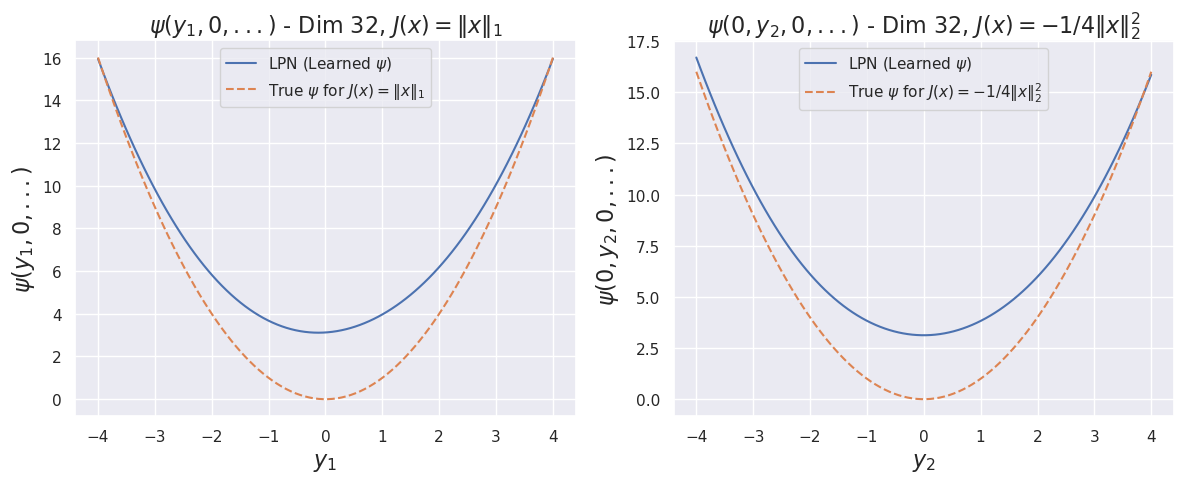

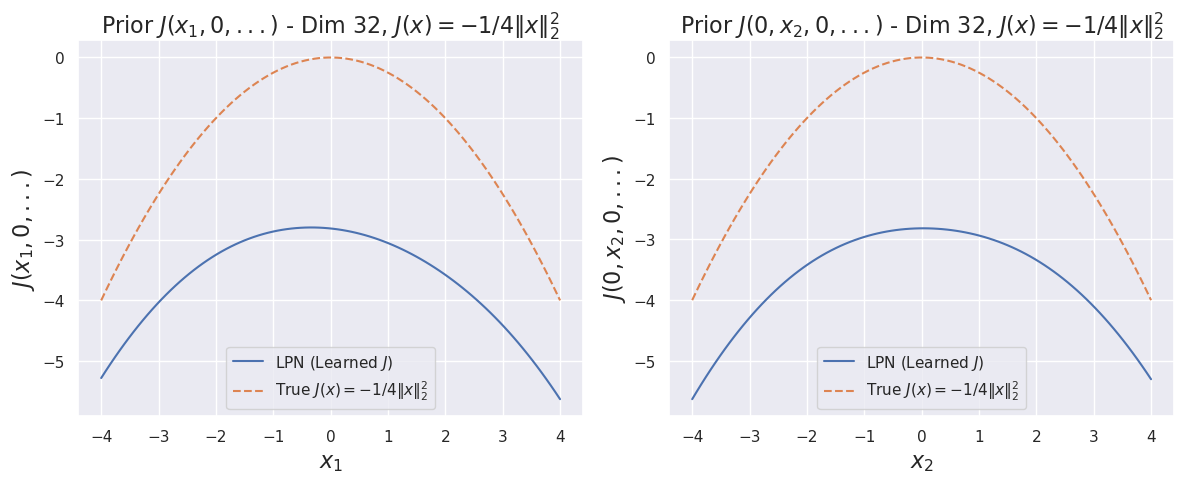

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-0.9450,  3.7073, -8.0271,  ...,  5.5555, -5.3722, -1.3198],
        [ 7.0011,  0.0469,  2.7970,  ..., -1.6029,  3.2407, -0.9485],
        [-7.6882,  0.8725,  2.4285,  ...,  1.3683, -1.8529, -4.1811],
        ...,
        [-6.0312,  4.7266,  6.7211,  ...,  1.6749,  0.6832,  0.6676],
        [ 0.0365, -6.1718,  5.1805,  ..., -3.6192, -1.8223,  6.1195],
        [-7.6815, -5.2056, -3.6512,  ..., -3.7239,  0.0809, -0.6895]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] /5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 27525.90625
iteration 0 loss 10227.6513671875


iteration 500 loss 137.42373657226562


iteration 1000 loss 118.06652069091797


iteration 1500 loss 111.89099884033203


iteration 2000 loss 108.94120025634766


iteration 2500 loss 106.10648345947266


iteration 3000 loss 103.00756072998047


iteration 3500 loss 99.6441650390625


iteration 4000 loss 96.0268325805664


iteration 4500 loss 92.18440246582031


iteration 5000 loss 88.11872100830078


iteration 5500 loss 83.77727508544922


iteration 6000 loss 79.05677032470703


iteration 6500 loss 73.79335021972656


iteration 7000 loss 67.17943572998047


iteration 7500 loss 56.64730453491211


iteration 8000 loss 35.67306900024414


iteration 8500 loss 17.33270835876465


iteration 9000 loss 10.859306335449219


iteration 9500 loss 8.0943603515625


iteration 10000 loss 6.36459493637085


iteration 10500 loss 5.041707515716553


iteration 11000 loss 4.510244369506836


iteration 11500 loss 4.029860019683838


iteration 12000 loss 3.5403573513031006


iteration 12500 loss 3.052887439727783


iteration 13000 loss 2.5913729667663574


iteration 13500 loss 2.480801582336426


iteration 14000 loss 2.3746745586395264


iteration 14500 loss 2.253364324569702


iteration 15000 loss 2.114943742752075


iteration 15500 loss 1.9598854780197144


iteration 16000 loss 1.7905625104904175


iteration 16500 loss 1.6137562990188599


iteration 17000 loss 1.5538368225097656


iteration 17500 loss 1.5110526084899902


iteration 18000 loss 1.4620749950408936


iteration 18500 loss 1.404556155204773


iteration 19000 loss 1.3374907970428467


iteration 19500 loss 1.2608404159545898


iteration 20000 loss 1.1762388944625854


iteration 20500 loss 1.1270514726638794


iteration 21000 loss 1.097823977470398


iteration 21500 loss 1.0642130374908447


iteration 22000 loss 1.0242571830749512


iteration 22500 loss 0.9772911667823792


iteration 23000 loss 1.4439709186553955


iteration 23500 loss 0.9158439040184021


iteration 24000 loss 0.9003728032112122


iteration 24500 loss 0.8827671408653259


iteration 25000 loss 0.8614044785499573


iteration 25500 loss 0.8355287909507751


iteration 26000 loss 0.8047722578048706


iteration 26500 loss 0.8426378965377808


iteration 27000 loss 0.7628514170646667


iteration 27500 loss 0.7502061128616333


iteration 28000 loss 0.7355086207389832


iteration 28500 loss 0.7176299095153809


iteration 29000 loss 0.6960472464561462


iteration 29500 loss 0.6707767844200134


iteration 30000 loss 0.6585628390312195


iteration 30500 loss 0.6478190422058105


iteration 31000 loss 0.6357772350311279


iteration 31500 loss 0.6211130023002625


iteration 32000 loss 0.6033745408058167


iteration 32500 loss 0.6072153449058533


iteration 33000 loss 0.5830124616622925


iteration 33500 loss 0.5762653350830078


iteration 34000 loss 0.5690390467643738


iteration 34500 loss 0.5603228211402893


iteration 35000 loss 0.5495769381523132


iteration 35500 loss 0.5363439321517944


iteration 36000 loss 0.5206466317176819


iteration 36500 loss 0.518802285194397


iteration 37000 loss 0.5125911235809326


iteration 37500 loss 0.5069040060043335


iteration 38000 loss 0.5003076791763306


iteration 38500 loss 0.4922458827495575


iteration 39000 loss 0.4823141396045685


iteration 39500 loss 0.47034159302711487


iteration 40000 loss 0.4667162001132965


iteration 40500 loss 0.46046116948127747


iteration 41000 loss 0.45582258701324463


iteration 41500 loss 0.45064008235931396


iteration 42000 loss 0.44432851672172546


iteration 42500 loss 0.43652236461639404


iteration 43000 loss 0.42701736092567444


iteration 43500 loss 0.42363327741622925


iteration 44000 loss 0.41638925671577454


iteration 44500 loss 0.41180354356765747


iteration 45000 loss 0.4066944122314453


iteration 45500 loss 0.40047773718833923


iteration 46000 loss 0.39285051822662354


iteration 46500 loss 0.39119216799736023


iteration 47000 loss 0.38426336646080017


iteration 47500 loss 0.38033387064933777


iteration 48000 loss 0.3760887086391449


iteration 48500 loss 0.3709460198879242


iteration 49000 loss 0.36462876200675964


iteration 49500 loss 1.942986249923706


iteration 50000 loss 0.358051061630249


iteration 50500 loss 0.3544083535671234


iteration 51000 loss 0.35128054022789


iteration 51500 loss 0.34776562452316284


iteration 52000 loss 0.34349822998046875


iteration 52500 loss 0.33827099204063416


iteration 53000 loss 0.33200445771217346


iteration 53500 loss 0.3305048644542694


iteration 54000 loss 0.32693812251091003


iteration 54500 loss 0.323550820350647


iteration 55000 loss 0.31950506567955017


iteration 55500 loss 0.31451764702796936


iteration 56000 loss 0.3178439140319824


iteration 56500 loss 0.310525506734848


iteration 57000 loss 0.3077482283115387


iteration 57500 loss 0.30532875657081604


iteration 58000 loss 0.3026338517665863


iteration 58500 loss 0.29937446117401123


iteration 59000 loss 0.29536259174346924


iteration 59500 loss 0.29058972001075745


iteration 60000 loss 0.29213041067123413


iteration 60500 loss 0.2887974679470062


iteration 61000 loss 0.28654900193214417


iteration 61500 loss 0.2843136787414551


iteration 62000 loss 0.28171318769454956


iteration 62500 loss 0.27852582931518555


iteration 63000 loss 0.27463436126708984


iteration 63500 loss 0.27420666813850403


iteration 64000 loss 0.27081942558288574


iteration 64500 loss 0.26864996552467346


iteration 65000 loss 0.26627781987190247


iteration 65500 loss 0.26339590549468994


iteration 66000 loss 0.2598589062690735


iteration 66500 loss 0.2616371512413025


iteration 67000 loss 0.2580345869064331


iteration 67500 loss 0.25603291392326355


iteration 68000 loss 0.25420942902565


iteration 68500 loss 0.2521454095840454


iteration 69000 loss 0.2496330440044403


iteration 69500 loss 0.24654677510261536


iteration 70000 loss 0.2459532618522644


iteration 70500 loss 0.24334751069545746


iteration 71000 loss 0.24131599068641663


iteration 71500 loss 0.23896324634552002


iteration 72000 loss 0.23610834777355194


iteration 72500 loss 0.23789501190185547


iteration 73000 loss 0.2349952608346939


iteration 73500 loss 0.23329313099384308


iteration 74000 loss 0.23173752427101135


iteration 74500 loss 0.2299923598766327


iteration 75000 loss 0.22788211703300476


iteration 75500 loss 0.22538217902183533


iteration 76000 loss 0.22540651261806488


iteration 76500 loss 0.2228606939315796


iteration 77000 loss 0.22124892473220825


iteration 77500 loss 0.2195023149251938


iteration 78000 loss 0.2173810452222824


iteration 78500 loss 0.8704406023025513


iteration 79000 loss 0.21553316712379456


iteration 79500 loss 0.21362115442752838


iteration 80000 loss 0.2121797800064087


iteration 80500 loss 0.21061956882476807


iteration 81000 loss 0.20876441895961761


iteration 81500 loss 0.843339741230011


iteration 82000 loss 0.20643934607505798


iteration 82500 loss 0.20476007461547852


iteration 83000 loss 0.20324888825416565


iteration 83500 loss 0.20149685442447662


iteration 84000 loss 0.9051156044006348


iteration 84500 loss 0.20105719566345215


iteration 85000 loss 0.19913849234580994


iteration 85500 loss 0.1978910267353058


iteration 86000 loss 0.1967155933380127


iteration 86500 loss 0.19538603723049164


iteration 87000 loss 0.19377587735652924


iteration 87500 loss 0.19181354343891144


iteration 88000 loss 0.19399239122867584


iteration 88500 loss 0.19166697561740875


iteration 89000 loss 0.19034530222415924


iteration 89500 loss 0.18923330307006836


iteration 90000 loss 0.18804562091827393


iteration 90500 loss 0.1866438239812851


iteration 91000 loss 0.18492019176483154


iteration 91500 loss 0.1858234852552414


iteration 92000 loss 0.18352249264717102


iteration 92500 loss 0.18234391510486603


iteration 93000 loss 0.1812017560005188


iteration 93500 loss 0.17985406517982483


iteration 94000 loss 0.1783108115196228


iteration 94500 loss 0.17980580031871796


iteration 95000 loss 0.17780159413814545


iteration 95500 loss 0.1767081767320633


iteration 96000 loss 0.17576813697814941


iteration 96500 loss 0.1747361272573471


iteration 97000 loss 0.17349117994308472


iteration 97500 loss 0.17197419703006744


iteration 98000 loss 0.1743323653936386


iteration 98500 loss 0.17193664610385895


iteration 99000 loss 0.17073005437850952


iteration 99500 loss 0.16980916261672974


Learning rate decreased to 2e-05 at iteration 100000
iteration 100000 loss 0.16887781023979187


iteration 100500 loss 0.16865487396717072


iteration 101000 loss 0.1683739423751831


iteration 101500 loss 0.1680188924074173


iteration 102000 loss 0.16757094860076904


iteration 102500 loss 0.16700460016727448


iteration 103000 loss 0.16628846526145935


iteration 103500 loss 0.165381520986557


iteration 104000 loss 0.1642349362373352


iteration 104500 loss 0.16280609369277954


iteration 105000 loss 0.16178205609321594


iteration 105500 loss 0.16127833724021912


iteration 106000 loss 0.16074824333190918


iteration 106500 loss 0.16008064150810242


iteration 107000 loss 0.1592363715171814


iteration 107500 loss 0.15817344188690186


iteration 108000 loss 0.15684852004051208


iteration 108500 loss 0.15614907443523407


iteration 109000 loss 0.1557052582502365


iteration 109500 loss 0.15532037615776062


iteration 110000 loss 0.15484772622585297


iteration 110500 loss 0.1542501449584961


iteration 111000 loss 0.15349318087100983


iteration 111500 loss 0.15254242718219757


iteration 112000 loss 0.15135592222213745


iteration 112500 loss 0.15071676671504974


iteration 113000 loss 0.1500742882490158


iteration 113500 loss 0.14973615109920502


iteration 114000 loss 0.14934055507183075


iteration 114500 loss 0.14884299039840698


iteration 115000 loss 0.14821171760559082


iteration 115500 loss 0.14741265773773193


iteration 116000 loss 0.14641138911247253


iteration 116500 loss 0.14517751336097717


iteration 117000 loss 0.14482788741588593


iteration 117500 loss 0.1444447636604309


iteration 118000 loss 0.14398375153541565


iteration 118500 loss 0.14339974522590637


iteration 119000 loss 0.14265908300876617


iteration 119500 loss 0.14172375202178955


iteration 120000 loss 0.14564445614814758


iteration 120500 loss 0.14045073091983795


iteration 121000 loss 0.140154168009758


iteration 121500 loss 0.13982528448104858


iteration 122000 loss 0.13941289484500885


iteration 122500 loss 0.13888965547084808


iteration 123000 loss 0.13822470605373383


iteration 123500 loss 0.13738855719566345


iteration 124000 loss 0.1363518089056015


iteration 124500 loss 0.136025071144104


iteration 125000 loss 0.1357187032699585


iteration 125500 loss 0.1354304403066635


iteration 126000 loss 0.135076105594635


iteration 126500 loss 0.1346273571252823


iteration 127000 loss 0.13405746221542358


iteration 127500 loss 0.1333375722169876


iteration 128000 loss 0.1324334293603897


iteration 128500 loss 0.1320374757051468


iteration 129000 loss 0.13165722787380219


iteration 129500 loss 0.1313953399658203


iteration 130000 loss 0.1310848742723465


iteration 130500 loss 0.13069364428520203


iteration 131000 loss 0.13019731640815735


iteration 131500 loss 0.12956835329532623


iteration 132000 loss 0.12879320979118347


iteration 132500 loss 0.12885986268520355


iteration 133000 loss 0.1278305947780609


iteration 133500 loss 0.12758220732212067


iteration 134000 loss 0.1273157298564911


iteration 134500 loss 0.1269850730895996


iteration 135000 loss 0.12656603753566742


iteration 135500 loss 0.12603452801704407


iteration 136000 loss 0.12536492943763733


iteration 136500 loss 0.1245303824543953


iteration 137000 loss 0.12428334355354309


iteration 137500 loss 0.1240282654762268


iteration 138000 loss 0.12378910928964615


iteration 138500 loss 0.12349498271942139


iteration 139000 loss 0.12312208116054535


iteration 139500 loss 0.12264768034219742


iteration 140000 loss 0.12204694747924805


iteration 140500 loss 0.12131328135728836


iteration 141000 loss 0.12100618332624435


iteration 141500 loss 0.12063836306333542


iteration 142000 loss 0.12041980773210526


iteration 142500 loss 0.12016696482896805


iteration 143000 loss 0.11984958499670029


iteration 143500 loss 0.11944618821144104


iteration 144000 loss 0.11893344670534134


iteration 144500 loss 0.11828771978616714


iteration 145000 loss 0.11828292906284332


iteration 145500 loss 0.1175188422203064


iteration 146000 loss 0.11730609834194183


iteration 146500 loss 0.11708252876996994


iteration 147000 loss 0.11680597811937332


iteration 147500 loss 0.1164550855755806


iteration 148000 loss 0.11600834876298904


iteration 148500 loss 0.11544352769851685


iteration 149000 loss 0.11474114656448364


iteration 149500 loss 0.1145666241645813


iteration 150000 loss 0.1143316775560379


iteration 150500 loss 0.11413001269102097


iteration 151000 loss 0.11388606578111649


iteration 151500 loss 0.11357798427343369


iteration 152000 loss 0.11318603157997131


iteration 152500 loss 0.11268864572048187


iteration 153000 loss 0.11208074539899826


iteration 153500 loss 0.11183090507984161


iteration 154000 loss 0.11153266578912735


iteration 154500 loss 0.11134422570466995


iteration 155000 loss 0.11112387478351593


iteration 155500 loss 0.11084707081317902


iteration 156000 loss 0.11049520969390869


iteration 156500 loss 0.110047847032547


iteration 157000 loss 0.10948427766561508


iteration 157500 loss 0.11142825335264206


iteration 158000 loss 0.10882551223039627


iteration 158500 loss 0.10863222181797028


iteration 159000 loss 0.10844113677740097


iteration 159500 loss 0.10820749402046204


iteration 160000 loss 0.10791178047657013


iteration 160500 loss 0.1075359359383583


iteration 161000 loss 0.10705989599227905


iteration 161500 loss 0.10646525770425797


iteration 162000 loss 0.10632779449224472


iteration 162500 loss 0.10609541088342667


iteration 163000 loss 0.10591944307088852


iteration 163500 loss 0.10571147501468658


iteration 164000 loss 0.10544972866773605


iteration 164500 loss 0.10511688143014908


iteration 165000 loss 0.10470043867826462


iteration 165500 loss 0.10416354984045029


iteration 166000 loss 0.10388537496328354


iteration 166500 loss 0.10362190753221512


iteration 167000 loss 0.1034327819943428


iteration 167500 loss 0.10320236533880234


iteration 168000 loss 0.10291057825088501


iteration 168500 loss 0.10254031419754028


iteration 169000 loss 0.1020755022764206


iteration 169500 loss 0.10242477804422379


iteration 170000 loss 0.1013970822095871


iteration 170500 loss 0.10118436068296432


iteration 171000 loss 0.10092519223690033


iteration 171500 loss 0.10059616714715958


iteration 172000 loss 0.10017827153205872


iteration 172500 loss 0.09965144842863083


iteration 173000 loss 0.09948308020830154


iteration 173500 loss 0.09927722066640854


iteration 174000 loss 0.09911835938692093


iteration 174500 loss 0.09892711788415909


iteration 175000 loss 0.09868539124727249


iteration 175500 loss 0.09837773442268372


iteration 176000 loss 0.0979873389005661


iteration 176500 loss 0.09750996530056


iteration 177000 loss 0.09737350791692734


iteration 177500 loss 0.0971231609582901


iteration 178000 loss 0.09697182476520538


iteration 178500 loss 0.09679920226335526


iteration 179000 loss 0.09658334404230118


iteration 179500 loss 0.09630925953388214


iteration 180000 loss 0.0959639847278595


iteration 180500 loss 0.09552924335002899


iteration 181000 loss 0.09560094028711319


iteration 181500 loss 0.09506084769964218


iteration 182000 loss 0.09490680694580078


iteration 182500 loss 0.09475645422935486


iteration 183000 loss 0.09457319974899292


iteration 183500 loss 0.09434167295694351


iteration 184000 loss 0.09404806047677994


iteration 184500 loss 0.09367728978395462


iteration 185000 loss 0.0932052731513977


iteration 185500 loss 0.09308943897485733


iteration 186000 loss 0.09290413558483124


iteration 186500 loss 0.0927681103348732


iteration 187000 loss 0.09260708093643188


iteration 187500 loss 0.09240420162677765


iteration 188000 loss 0.092146135866642


iteration 188500 loss 0.09181802719831467


iteration 189000 loss 0.09140558540821075


iteration 189500 loss 0.09132035821676254


iteration 190000 loss 0.09099995344877243


iteration 190500 loss 0.09086728096008301


iteration 191000 loss 0.0907229334115982


iteration 191500 loss 0.0905432254076004


iteration 192000 loss 0.09031504392623901


iteration 192500 loss 0.09002464264631271


iteration 193000 loss 0.08965706080198288


iteration 193500 loss 0.14884880185127258


iteration 194000 loss 0.08922030031681061


iteration 194500 loss 0.08906939625740051


iteration 195000 loss 0.0889391154050827


iteration 195500 loss 0.08878380805253983


iteration 196000 loss 0.0885884016752243


iteration 196500 loss 0.08833976835012436


iteration 197000 loss 0.08802387118339539


iteration 197500 loss 0.08764561265707016


iteration 198000 loss 0.08755994588136673


iteration 198500 loss 0.08731356263160706


iteration 199000 loss 0.08718754351139069


iteration 199500 loss 0.08704971522092819


Learning rate decreased to 4.000000000000001e-06 at iteration 200000
iteration 200000 loss 0.08687838166952133


iteration 200500 loss 0.08683476597070694


iteration 201000 loss 0.08677799999713898


iteration 201500 loss 0.08670628070831299


iteration 202000 loss 0.0866147056221962


iteration 202500 loss 0.08649764209985733


iteration 203000 loss 0.0863478034734726


iteration 203500 loss 0.08615682274103165


iteration 204000 loss 0.08591341972351074


iteration 204500 loss 0.08560498058795929


iteration 205000 loss 0.08521822094917297


iteration 205500 loss 0.08500935137271881


iteration 206000 loss 0.08492361754179001


iteration 206500 loss 0.08481474220752716


iteration 207000 loss 0.08467546105384827


iteration 207500 loss 0.08449780195951462


iteration 208000 loss 0.08427133411169052


iteration 208500 loss 0.08398345857858658


iteration 209000 loss 0.08362208306789398


iteration 209500 loss 0.08334803581237793


iteration 210000 loss 0.0832115188241005


iteration 210500 loss 0.08303772658109665


iteration 211000 loss 0.08281618356704712


iteration 211500 loss 0.08253449201583862


iteration 212000 loss 0.08217939734458923


iteration 212500 loss 0.08198124915361404


iteration 213000 loss 0.08190266788005829


iteration 213500 loss 0.0818033516407013


iteration 214000 loss 0.08167614787817001


iteration 214500 loss 0.08151376247406006


iteration 215000 loss 0.08130662888288498


iteration 215500 loss 0.08104311674833298


iteration 216000 loss 0.08071067929267883


iteration 216500 loss 0.08047061413526535


iteration 217000 loss 0.08039629459381104


iteration 217500 loss 0.08030439913272858


iteration 218000 loss 0.0801868736743927


iteration 218500 loss 0.0800367221236229


iteration 219000 loss 0.07984501868486404


iteration 219500 loss 0.07960136234760284


iteration 220000 loss 0.07929395884275436


iteration 220500 loss 0.07901251316070557


iteration 221000 loss 0.0789397582411766


iteration 221500 loss 0.07885631173849106


iteration 222000 loss 0.0787496566772461


iteration 222500 loss 0.07861317694187164


iteration 223000 loss 0.07843901216983795


iteration 223500 loss 0.07821699976921082


iteration 224000 loss 0.07793585956096649


iteration 224500 loss 0.07782787084579468


iteration 225000 loss 0.07749078422784805


iteration 225500 loss 0.07735387980937958


iteration 226000 loss 0.07717911899089813


iteration 226500 loss 0.0769561231136322


iteration 227000 loss 0.0766732394695282


iteration 227500 loss 0.07639381289482117


iteration 228000 loss 0.07632467895746231


iteration 228500 loss 0.07624585926532745


iteration 229000 loss 0.07614526152610779


iteration 229500 loss 0.07601640373468399


iteration 230000 loss 0.07585175335407257


iteration 230500 loss 0.07564184069633484


iteration 231000 loss 0.07537580281496048


iteration 231500 loss 0.07767048478126526


iteration 232000 loss 0.07499969005584717


iteration 232500 loss 0.07492616027593613


iteration 233000 loss 0.07483255118131638


iteration 233500 loss 0.0747126042842865


iteration 234000 loss 0.07455954700708389


iteration 234500 loss 0.074364073574543


iteration 235000 loss 0.07411636412143707


iteration 235500 loss 0.0738053172826767


iteration 236000 loss 0.0737093836069107


iteration 236500 loss 0.07364276051521301


iteration 237000 loss 0.07355812191963196


iteration 237500 loss 0.07344967126846313


iteration 238000 loss 0.07331106811761856


iteration 238500 loss 0.07313434034585953


iteration 239000 loss 0.07290957868099213


iteration 239500 loss 0.07262658327817917


iteration 240000 loss 0.07243401557207108


iteration 240500 loss 0.07237169146537781


iteration 241000 loss 0.07229486852884293


iteration 241500 loss 0.07219679653644562


iteration 242000 loss 0.07207133620977402


iteration 242500 loss 0.0719112753868103


iteration 243000 loss 0.07170741260051727


iteration 243500 loss 0.0714501142501831


iteration 244000 loss 0.0712103322148323


iteration 244500 loss 0.07114839553833008


iteration 245000 loss 0.0710802972316742


iteration 245500 loss 0.07099337875843048


iteration 246000 loss 0.07088229805231094


iteration 246500 loss 0.07074026763439178


iteration 247000 loss 0.07055941969156265


iteration 247500 loss 0.07033053040504456


iteration 248000 loss 0.07004260271787643


iteration 248500 loss 0.0699506402015686


iteration 249000 loss 0.06986744701862335


iteration 249500 loss 0.06976110488176346


iteration 250000 loss 0.06962530314922333


iteration 250500 loss 0.06945210695266724


iteration 251000 loss 0.06923229992389679


iteration 251500 loss 0.06895678490400314


iteration 252000 loss 0.06886652112007141


iteration 252500 loss 0.06880830973386765


iteration 253000 loss 0.06873469054698944


iteration 253500 loss 0.06864051520824432


iteration 254000 loss 0.06852000951766968


iteration 254500 loss 0.06836630403995514


iteration 255000 loss 0.06817078590393066


iteration 255500 loss 0.06792397797107697


iteration 256000 loss 0.0677516832947731


iteration 256500 loss 0.06769859790802002


iteration 257000 loss 0.06763266772031784


iteration 257500 loss 0.06754866987466812


iteration 258000 loss 0.06744083762168884


iteration 258500 loss 0.06730330735445023


iteration 259000 loss 0.06712798029184341


iteration 259500 loss 0.06690574437379837


iteration 260000 loss 0.06668366491794586


iteration 260500 loss 0.06662476807832718


iteration 261000 loss 0.06656119227409363


iteration 261500 loss 0.06648000329732895


iteration 262000 loss 0.06637600809335709


iteration 262500 loss 0.06624316424131393


iteration 263000 loss 0.06607382744550705


iteration 263500 loss 0.06585974991321564


iteration 264000 loss 0.06565427035093307


iteration 264500 loss 0.06558683514595032


iteration 265000 loss 0.06553144752979279


iteration 265500 loss 0.06546110659837723


iteration 266000 loss 0.06537114828824997


iteration 266500 loss 0.06525599956512451


iteration 267000 loss 0.06510905176401138


iteration 267500 loss 0.06492211669683456


iteration 268000 loss 0.06468667089939117


iteration 268500 loss 0.06458088010549545


iteration 269000 loss 0.06452804058790207


iteration 269500 loss 0.06446125358343124


iteration 270000 loss 0.0643758550286293


iteration 270500 loss 0.06426656246185303


iteration 271000 loss 0.06412716954946518


iteration 271500 loss 0.06394997984170914


iteration 272000 loss 0.06372588872909546


iteration 272500 loss 0.0635993480682373


iteration 273000 loss 0.06352756172418594


iteration 273500 loss 0.0634358823299408


iteration 274000 loss 0.06331879645586014


iteration 274500 loss 0.06316927075386047


iteration 275000 loss 0.0629790648818016


iteration 275500 loss 0.06289190798997879


iteration 276000 loss 0.06271488219499588


iteration 276500 loss 0.0626654103398323


iteration 277000 loss 0.06260284036397934


iteration 277500 loss 0.06252281367778778


iteration 278000 loss 0.062420401722192764


iteration 278500 loss 0.062289733439683914


iteration 279000 loss 0.062123410403728485


iteration 279500 loss 0.06191375106573105


iteration 280000 loss 0.06179560348391533


iteration 280500 loss 0.061749886721372604


iteration 281000 loss 0.061693597584962845


iteration 281500 loss 0.06162158027291298


iteration 282000 loss 0.061529193073511124


iteration 282500 loss 0.061411187052726746


iteration 283000 loss 0.06126072257757187


iteration 283500 loss 0.06107029318809509


iteration 284000 loss 0.06090503931045532


iteration 284500 loss 0.06085930019617081


iteration 285000 loss 0.06080802530050278


iteration 285500 loss 0.06074279174208641


iteration 286000 loss 0.0606590136885643


iteration 286500 loss 0.0605519637465477


iteration 287000 loss 0.06041545420885086


iteration 287500 loss 0.06024183705449104


iteration 288000 loss 0.060023318976163864


iteration 288500 loss 0.059982676059007645


iteration 289000 loss 0.05993809551000595


iteration 289500 loss 0.05988201126456261


iteration 290000 loss 0.05981023982167244


iteration 290500 loss 0.0597183033823967


iteration 291000 loss 0.059600938111543655


iteration 291500 loss 0.05945134907960892


iteration 292000 loss 0.05926275625824928


iteration 292500 loss 0.059137895703315735


iteration 293000 loss 0.05909660458564758


iteration 293500 loss 0.05904647707939148


iteration 294000 loss 0.05898258090019226


iteration 294500 loss 0.05890059843659401


iteration 295000 loss 0.05879582464694977


iteration 295500 loss 0.0586620531976223


iteration 296000 loss 0.058491747826337814


iteration 296500 loss 0.05833262950181961


iteration 297000 loss 0.058269061148166656


iteration 297500 loss 0.05822424963116646


iteration 298000 loss 0.05816742405295372


iteration 298500 loss 0.05809466913342476


iteration 299000 loss 0.058001402765512466


iteration 299500 loss 0.05788233503699303


Learning rate decreased to 8.000000000000002e-07 at iteration 300000
iteration 300000 loss 0.05773055925965309


iteration 300500 loss 0.05769144743680954


iteration 301000 loss 0.05764196813106537


iteration 301500 loss 0.05757901445031166


iteration 302000 loss 0.05749877914786339


iteration 302500 loss 0.057397447526454926


iteration 303000 loss 0.05727007985115051


iteration 303500 loss 0.05711148679256439


iteration 304000 loss 0.056943099945783615


iteration 304500 loss 0.05684221163392067


iteration 305000 loss 0.0567154698073864


iteration 305500 loss 0.05655773729085922


iteration 306000 loss 0.056406401097774506


iteration 306500 loss 0.056338243186473846


iteration 307000 loss 0.056251611560583115


iteration 307500 loss 0.05614274740219116


iteration 308000 loss 0.05600639432668686


iteration 308500 loss 0.05583819001913071


iteration 309000 loss 0.055715978145599365


iteration 309500 loss 0.055604636669158936


iteration 310000 loss 0.0554654523730278


iteration 310500 loss 0.055293772369623184


iteration 311000 loss 0.055197734385728836


iteration 311500 loss 0.0550934262573719


iteration 312000 loss 0.05496282875537872


iteration 312500 loss 0.054801180958747864


iteration 313000 loss 0.05468359217047691


iteration 313500 loss 0.054580748081207275


iteration 314000 loss 0.05445190146565437


iteration 314500 loss 0.054292578250169754


iteration 315000 loss 0.05419011041522026


iteration 315500 loss 0.05410610884428024


iteration 316000 loss 0.054000504314899445


iteration 316500 loss 0.05386856570839882


iteration 317000 loss 0.053706053644418716


iteration 317500 loss 0.053613897413015366


iteration 318000 loss 0.05351610481739044


iteration 318500 loss 0.053393371403217316


iteration 319000 loss 0.05324164777994156


iteration 319500 loss 0.05312654748558998


iteration 320000 loss 0.053029607981443405


iteration 320500 loss 0.052908092737197876


iteration 321000 loss 0.05275760963559151


iteration 321500 loss 0.05265148729085922


iteration 322000 loss 0.05256282910704613


iteration 322500 loss 0.0524514876306057


iteration 323000 loss 0.05231297388672829


iteration 323500 loss 0.052181292325258255


iteration 324000 loss 0.0520886592566967


iteration 324500 loss 0.05197247117757797


iteration 325000 loss 0.05182855203747749


iteration 325500 loss 0.05173487961292267


iteration 326000 loss 0.05167149007320404


iteration 326500 loss 0.05159131437540054


iteration 327000 loss 0.05149049684405327


iteration 327500 loss 0.05136478319764137


iteration 328000 loss 0.05121701583266258


iteration 328500 loss 0.051140982657670975


iteration 329000 loss 0.051045823842287064


iteration 329500 loss 0.05092673376202583


iteration 330000 loss 0.05077981576323509


iteration 330500 loss 0.05069638788700104


iteration 331000 loss 0.05060505121946335


iteration 331500 loss 0.05049062520265579


iteration 332000 loss 0.050349149852991104


iteration 332500 loss 0.050265878438949585


iteration 333000 loss 0.05018831789493561


iteration 333500 loss 0.050090912729501724


iteration 334000 loss 0.049969255924224854


iteration 334500 loss 0.04983530938625336


iteration 335000 loss 0.049777593463659286


iteration 335500 loss 0.04970439150929451


iteration 336000 loss 0.049612339586019516


iteration 336500 loss 0.049497153609991074


iteration 337000 loss 0.04935619235038757


iteration 337500 loss 0.049296990036964417


iteration 338000 loss 0.04922536015510559


iteration 338500 loss 0.04913513734936714


iteration 339000 loss 0.04902230575680733


iteration 339500 loss 0.04888300225138664


iteration 340000 loss 0.04880712926387787


iteration 340500 loss 0.0487191379070282


iteration 341000 loss 0.04860882833600044


iteration 341500 loss 0.04847249016165733


iteration 342000 loss 0.048421021550893784


iteration 342500 loss 0.04836851730942726


iteration 343000 loss 0.04830176383256912


iteration 343500 loss 0.04821772500872612


iteration 344000 loss 0.04811224713921547


iteration 344500 loss 0.04798182100057602


iteration 345000 loss 0.04791433364152908


iteration 345500 loss 0.04785432666540146


iteration 346000 loss 0.047778427600860596


iteration 346500 loss 0.04768309369683266


iteration 347000 loss 0.04756441339850426


iteration 347500 loss 0.047466911375522614


iteration 348000 loss 0.04742477461695671


iteration 348500 loss 0.04737120121717453


iteration 349000 loss 0.04730316624045372


iteration 349500 loss 0.047217510640621185


iteration 350000 loss 0.047110334038734436


iteration 350500 loss 0.04698207229375839


iteration 351000 loss 0.046936240047216415


iteration 351500 loss 0.04687914624810219


iteration 352000 loss 0.04680691286921501


iteration 352500 loss 0.04671604931354523


iteration 353000 loss 0.04660279303789139


iteration 353500 loss 0.0465051494538784


iteration 354000 loss 0.04646411910653114


iteration 354500 loss 0.04641202092170715


iteration 355000 loss 0.04634590074419975


iteration 355500 loss 0.046262603253126144


iteration 356000 loss 0.04615844041109085


iteration 356500 loss 0.046033915132284164


iteration 357000 loss 0.045965563505887985


iteration 357500 loss 0.04588085785508156


iteration 358000 loss 0.045774638652801514


iteration 358500 loss 0.04566648602485657


iteration 359000 loss 0.04562865570187569


iteration 359500 loss 0.045580826699733734


iteration 360000 loss 0.04551997780799866


iteration 360500 loss 0.045443225651979446


iteration 361000 loss 0.045346859842538834


iteration 361500 loss 0.045227598398923874


iteration 362000 loss 0.045152485370635986


iteration 362500 loss 0.04507577419281006


iteration 363000 loss 0.044979341328144073


iteration 363500 loss 0.044859878718853


iteration 364000 loss 0.04481456056237221


iteration 364500 loss 0.04477265849709511


iteration 365000 loss 0.04471960291266441


iteration 365500 loss 0.044652216136455536


iteration 366000 loss 0.04456758126616478


iteration 366500 loss 0.044461920857429504


iteration 367000 loss 0.04437374696135521


iteration 367500 loss 0.044335462152957916


iteration 368000 loss 0.044286880642175674


iteration 368500 loss 0.0442253015935421


iteration 369000 loss 0.04414759576320648


iteration 369500 loss 0.04405044764280319


iteration 370000 loss 0.04393483325839043


iteration 370500 loss 0.04389680176973343


iteration 371000 loss 0.04384900629520416


iteration 371500 loss 0.04378827288746834


iteration 372000 loss 0.04371166229248047


iteration 372500 loss 0.04361576959490776


iteration 373000 loss 0.04350556433200836


iteration 373500 loss 0.0434645377099514


iteration 374000 loss 0.043412499129772186


iteration 374500 loss 0.04334655776619911


iteration 375000 loss 0.043263696134090424


iteration 375500 loss 0.04316034913063049


iteration 376000 loss 0.043084535747766495


iteration 376500 loss 0.0430448055267334


iteration 377000 loss 0.04299430921673775


iteration 377500 loss 0.042930200695991516


iteration 378000 loss 0.04284962639212608


iteration 378500 loss 0.04274919629096985


iteration 379000 loss 0.0426693819463253


iteration 379500 loss 0.04263581335544586


iteration 380000 loss 0.04259336739778519


iteration 380500 loss 0.04253938049077988


iteration 381000 loss 0.04247113689780235


iteration 381500 loss 0.04238557815551758


iteration 382000 loss 0.04227934032678604


iteration 382500 loss 0.04222410172224045


iteration 383000 loss 0.04217931628227234


iteration 383500 loss 0.04212246462702751


iteration 384000 loss 0.042050670832395554


iteration 384500 loss 0.04196079075336456


iteration 385000 loss 0.04185618832707405


iteration 385500 loss 0.041811615228652954


iteration 386000 loss 0.04175533354282379


iteration 386500 loss 0.04168412834405899


iteration 387000 loss 0.04159512743353844


iteration 387500 loss 0.04149172082543373


iteration 388000 loss 0.041445471346378326


iteration 388500 loss 0.041386913508176804


iteration 389000 loss 0.04131319001317024


iteration 389500 loss 0.04122098907828331


iteration 390000 loss 0.04113762080669403


iteration 390500 loss 0.04110082983970642


iteration 391000 loss 0.0410541370511055


iteration 391500 loss 0.040994782000780106


iteration 392000 loss 0.040920190513134


iteration 392500 loss 0.04082704707980156


iteration 393000 loss 0.040748581290245056


iteration 393500 loss 0.04069923609495163


iteration 394000 loss 0.04063663259148598


iteration 394500 loss 0.04055798798799515


iteration 395000 loss 0.04046010598540306


iteration 395500 loss 0.0403972826898098


iteration 396000 loss 0.04033922031521797


iteration 396500 loss 0.04026612266898155


iteration 397000 loss 0.04017474874854088


iteration 397500 loss 0.04010716453194618


iteration 398000 loss 0.04007583484053612


iteration 398500 loss 0.04003619775176048


iteration 399000 loss 0.039985861629247665


iteration 399500 loss 0.03992209956049919


Learning rate decreased to 1.6000000000000003e-07 at iteration 400000
iteration 400000 loss 0.03984207659959793


iteration 400500 loss 0.03982182592153549


iteration 401000 loss 0.039796922355890274


iteration 401500 loss 0.03976643830537796


iteration 402000 loss 0.039729807525873184


iteration 402500 loss 0.039686478674411774


iteration 403000 loss 0.039635900408029556


iteration 403500 loss 0.03957827761769295


iteration 404000 loss 0.039514295756816864


iteration 404500 loss 0.039449069648981094


iteration 405000 loss 0.03938442841172218


iteration 405500 loss 0.03932024911046028


iteration 406000 loss 0.039256658405065536


iteration 406500 loss 0.03919338807463646


iteration 407000 loss 0.03913050889968872


iteration 407500 loss 0.039068154990673065


iteration 408000 loss 0.03900597244501114


iteration 408500 loss 0.03894428536295891


iteration 409000 loss 0.03888305649161339


iteration 409500 loss 0.03882191330194473


iteration 410000 loss 0.03876110911369324


iteration 410500 loss 0.03870069235563278


iteration 411000 loss 0.038640499114990234


iteration 411500 loss 0.03858062997460365


iteration 412000 loss 0.03852115944027901


iteration 412500 loss 0.03846188634634018


iteration 413000 loss 0.03840279579162598


iteration 413500 loss 0.03834410756826401


iteration 414000 loss 0.038285594433546066


iteration 414500 loss 0.0382273830473423


iteration 415000 loss 0.03816917538642883


iteration 415500 loss 0.038111612200737


iteration 416000 loss 0.038054052740335464


iteration 416500 loss 0.03799648955464363


iteration 417000 loss 0.0379391610622406


iteration 417500 loss 0.037882257252931595


iteration 418000 loss 0.0378253310918808


iteration 418500 loss 0.03776884078979492


iteration 419000 loss 0.03771224990487099


iteration 419500 loss 0.0376560278236866


iteration 420000 loss 0.037600088864564896


iteration 420500 loss 0.03754439577460289


iteration 421000 loss 0.0374886691570282


iteration 421500 loss 0.037432968616485596


iteration 422000 loss 0.037377577275037766


iteration 422500 loss 0.03732229024171829


iteration 423000 loss 0.037267327308654785


iteration 423500 loss 0.03721245750784874


iteration 424000 loss 0.037157680839300156


iteration 424500 loss 0.03710306063294411


iteration 425000 loss 0.03704862296581268


iteration 425500 loss 0.03699440136551857


iteration 426000 loss 0.03694045916199684


iteration 426500 loss 0.03688659146428108


iteration 427000 loss 0.036833036690950394


iteration 427500 loss 0.03677939251065254


iteration 428000 loss 0.0367262102663517


iteration 428500 loss 0.03667303919792175


iteration 429000 loss 0.03661995753645897


iteration 429500 loss 0.03656716272234917


iteration 430000 loss 0.036514416337013245


iteration 430500 loss 0.03646177798509598


iteration 431000 loss 0.03640925884246826


iteration 431500 loss 0.036356907337903976


iteration 432000 loss 0.03630463778972626


iteration 432500 loss 0.036252692341804504


iteration 433000 loss 0.036200687289237976


iteration 433500 loss 0.03614883869886398


iteration 434000 loss 0.03609718382358551


iteration 434500 loss 0.03604552522301674


iteration 435000 loss 0.035994067788124084


iteration 435500 loss 0.035942818969488144


iteration 436000 loss 0.0358915701508522


iteration 436500 loss 0.03584056347608566


iteration 437000 loss 0.03578970208764076


iteration 437500 loss 0.035738956183195114


iteration 438000 loss 0.03568828105926514


iteration 438500 loss 0.035637833178043365


iteration 439000 loss 0.03558749333024025


iteration 439500 loss 0.03553727641701698


iteration 440000 loss 0.035487040877342224


iteration 440500 loss 0.035436972975730896


iteration 441000 loss 0.035387102514505386


iteration 441500 loss 0.03533725440502167


iteration 442000 loss 0.03528758883476257


iteration 442500 loss 0.03523843735456467


iteration 443000 loss 0.03518908470869064


iteration 443500 loss 0.035139720886945724


iteration 444000 loss 0.035090431571006775


iteration 444500 loss 0.03504164144396782


iteration 445000 loss 0.03499269858002663


iteration 445500 loss 0.03494437411427498


iteration 446000 loss 0.03489579260349274


iteration 446500 loss 0.03484721481800079


iteration 447000 loss 0.03479882702231407


iteration 447500 loss 0.03475040942430496


iteration 448000 loss 0.034702323377132416


iteration 448500 loss 0.034654002636671066


iteration 449000 loss 0.03460634499788284


iteration 449500 loss 0.03455846384167671


iteration 450000 loss 0.03451107069849968


iteration 450500 loss 0.03446391969919205


iteration 451000 loss 0.034416139125823975


iteration 451500 loss 0.034368570894002914


iteration 452000 loss 0.03432102128863335


iteration 452500 loss 0.03427357226610184


iteration 453000 loss 0.03422621637582779


iteration 453500 loss 0.03417893499135971


iteration 454000 loss 0.03413164243102074


iteration 454500 loss 0.03408455848693848


iteration 455000 loss 0.03403754532337189


iteration 455500 loss 0.033990707248449326


iteration 456000 loss 0.03394384682178497


iteration 456500 loss 0.03389706462621689


iteration 457000 loss 0.03385040536522865


iteration 457500 loss 0.03380391001701355


iteration 458000 loss 0.03375759720802307


iteration 458500 loss 0.033711228519678116


iteration 459000 loss 0.033665068447589874


iteration 459500 loss 0.03361887112259865


iteration 460000 loss 0.0335729755461216


iteration 460500 loss 0.03352702036499977


iteration 461000 loss 0.03348119184374809


iteration 461500 loss 0.03343544527888298


iteration 462000 loss 0.033389825373888016


iteration 462500 loss 0.03334439918398857


iteration 463000 loss 0.03329893574118614


iteration 463500 loss 0.03325356915593147


iteration 464000 loss 0.03320828452706337


iteration 464500 loss 0.03316309303045273


iteration 465000 loss 0.03311796858906746


iteration 465500 loss 0.033072952181100845


iteration 466000 loss 0.033028002828359604


iteration 466500 loss 0.0329832099378109


iteration 467000 loss 0.03293853625655174


iteration 467500 loss 0.03289387747645378


iteration 468000 loss 0.03284928947687149


iteration 468500 loss 0.03280482441186905


iteration 469000 loss 0.03276052325963974


iteration 469500 loss 0.03271612897515297


iteration 470000 loss 0.0326719656586647


iteration 470500 loss 0.03262796252965927


iteration 471000 loss 0.032583948224782944


iteration 471500 loss 0.03254000097513199


iteration 472000 loss 0.03249618783593178


iteration 472500 loss 0.032452359795570374


iteration 473000 loss 0.03240874037146568


iteration 473500 loss 0.03236524388194084


iteration 474000 loss 0.032321665436029434


iteration 474500 loss 0.03227832540869713


iteration 475000 loss 0.03223500773310661


iteration 475500 loss 0.03219173476099968


iteration 476000 loss 0.032148491591215134


iteration 476500 loss 0.03210538253188133


iteration 477000 loss 0.032062359154224396


iteration 477500 loss 0.03201941400766373


iteration 478000 loss 0.031976573169231415


iteration 478500 loss 0.03193381428718567


iteration 479000 loss 0.0318911112844944


iteration 479500 loss 0.03184855729341507


iteration 480000 loss 0.031805992126464844


iteration 480500 loss 0.031763505190610886


iteration 481000 loss 0.03172120451927185


iteration 481500 loss 0.0316789411008358


iteration 482000 loss 0.03163682296872139


iteration 482500 loss 0.03159470856189728


iteration 483000 loss 0.03155273199081421


iteration 483500 loss 0.03151080384850502


iteration 484000 loss 0.0314689502120018


iteration 484500 loss 0.03142723813652992


iteration 485000 loss 0.03138554468750954


iteration 485500 loss 0.03134391829371452


iteration 486000 loss 0.031302306801080704


iteration 486500 loss 0.03126083314418793


iteration 487000 loss 0.03121950663626194


iteration 487500 loss 0.031178118661046028


iteration 488000 loss 0.031136903911828995


iteration 488500 loss 0.031095702201128006


iteration 489000 loss 0.031054629012942314


iteration 489500 loss 0.03101351298391819


iteration 490000 loss 0.030972564592957497


iteration 490500 loss 0.03093162551522255


iteration 491000 loss 0.03089078888297081


iteration 491500 loss 0.030850017443299294


iteration 492000 loss 0.030809316784143448


iteration 492500 loss 0.030768699944019318


iteration 493000 loss 0.03072822280228138


iteration 493500 loss 0.0306877251714468


iteration 494000 loss 0.03064739517867565


iteration 494500 loss 0.030607091262936592


iteration 495000 loss 0.030566899105906487


iteration 495500 loss 0.030526768416166306


iteration 496000 loss 0.03048665076494217


iteration 496500 loss 0.030446672812104225


iteration 497000 loss 0.03040693886578083


iteration 497500 loss 0.03036709502339363


iteration 498000 loss 0.030327342450618744


iteration 498500 loss 0.030287880450487137


iteration 499000 loss 0.03024817816913128


iteration 499500 loss 0.03020857460796833


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


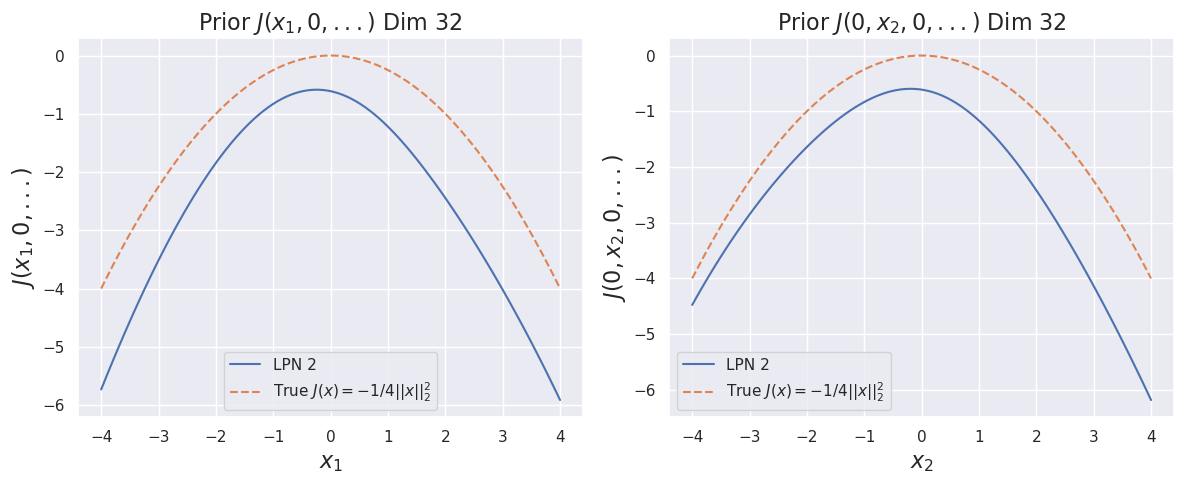

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)